In [3]:
!pip install transformers datasets sentence-transformers schedule

In [4]:
import time
import schedule
import random
import csv # Pour la collecte des résultats
from datetime import datetime
from transformers import pipeline, set_seed
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset

# Configuration des modèles
GENERATION_MODELS = {
    "DistilGPT2": 'distilgpt2',
    "T5 Small": 't5-small',
    "Flan-T5-Small": 'google/flan-t5-small'
}

SUMMARIZATION_MODELS = {
    "DistilGPT2": 'distilgpt2',
    "T5 Small": 't5-small',
    "Flan-T5-Small": 'google/flan-t5-small'
}

class PipelineTester:
    def __init__(self):
        print("Initialisation du Pipeline CPU-Friendly (Tester)...")
        self.qc_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
        self.banned_words = ["hate", "violence", "illegal", "badword"]
        self.results = []
        self.data_subset = self.load_data()

    def load_model(self, task, model_name):
        """Charge un modèle spécifique pour une tâche donnée."""
        try:
            if task == 'generation':
                pipe = pipeline(
                    'text-generation',
                    model=model_name,
                    device=-1, # Force CPU
                    pad_token_id=50256
                )
            elif task == 'summarization':
                pipe = pipeline(
                    'summarization',
                    model=model_name,
                    device=-1 # Force CPU
                )
            else:
                raise ValueError(f"Tâche inconnue: {task}")
            return pipe
        except Exception as e:
            print(f"Erreur de chargement du modèle {model_name} pour {task}: {e}")
            return None

    def load_data(self):
        """Charge et subsample 5% du dataset IMDB"""
        print("Chargement du dataset IMDB...")
        dataset = load_dataset("imdb", split="train")
        total_rows = len(dataset)
        subset_size = int(total_rows * 0.05)
        print(f"Subsampling : Conservation de {subset_size} exemples sur {total_rows} (5%)")
        # On utilise le temps actuel comme graine pour que le mélange soit différent à chaque fois
        return dataset.shuffle(seed=int(time.time())).select(range(subset_size))

    def ethical_filter(self, text):
        """Filtre éthique basique"""
        text_lower = text.lower()
        for word in self.banned_words:
            if word in text_lower:
                return False
        return True

    def evaluate_quality(self, prompt, generated_text, summary):
        """Évaluation et QC"""
        metrics = {}

        # 1. Longueur
        metrics['length_words'] = len(generated_text.split())
        metrics['length_ok'] = metrics['length_words'] > 20

        # 2. Répétition (Div)
        words = generated_text.split()
        unique_words = set(words)
        metrics['repetition_ratio'] = len(unique_words) / len(words) if words else 0
        metrics['div_ok'] = metrics['repetition_ratio'] > 0.5

        # 3. Similarité Sémantique (Mots clés / Cohérence)
        embeddings = self.qc_model.encode([prompt, summary], convert_to_tensor=True)
        similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
        metrics['semantic_score'] = similarity
        metrics['sem_ok'] = metrics['semantic_score'] > 0.3

        # Efficacité RAG (ici, Efficacité Prompt-Cohérence)
        metrics['rag_vs_pipeline'] = 1 if metrics['sem_ok'] and metrics['div_ok'] else 0

        # Décision globale
        is_valid = metrics['length_ok'] and metrics['div_ok'] and metrics['sem_ok']

        return is_valid, metrics

    def process_item_with_models(self, prompt_text, generator, summarizer, gen_name, sum_name):
        """Exécute le pipeline pour un item avec des modèles spécifiques et mesure le temps."""
        start_time = time.time()

        # --- 1. Génération (RAG - Temps de traitement) ---
        time_gen_start = time.time()
        gen_output = generator(
            prompt_text,
            max_new_tokens=100,
            truncation=True
        )
        generated_text = gen_output[0]['generated_text'].strip()
        time_gen_end = time.time()

        # --- 2. Filtre Éthique (Ethique - Temps de traitement O(1)) ---
        time_ethic_start = time.time()
        is_ethical = self.ethical_filter(generated_text)
        time_ethic_end = time.time()

        if not is_ethical:
            return None, "REJET_ETHIQUE", {
                'gen_time': time_gen_end - time_gen_start,
                'sum_time': 0,
                'qc_time': 0,
                'ethic_time': time_ethic_end - time_ethic_start,
                'total_time': time.time() - start_time
            }

        # --- 3. Résumé (Résumé - Temps de traitement) ---
        time_sum_start = time.time()
        # Préfixe adapté pour T5/Flan-T5
        if "T5" in sum_name:
            input_text = "summarize: " + generated_text
        else:
            input_text = generated_text

        sum_output = summarizer(
            input_text,
            max_length=40,
            min_length=5,
            do_sample=False
        )
        summary_text = sum_output[0]['summary_text'].strip()
        time_sum_end = time.time()

        # --- 4. Évaluation (Contrôle qualité - Temps de traitement) ---
        time_qc_start = time.time()
        is_valid, metrics = self.evaluate_quality(prompt_text, generated_text, summary_text)
        time_qc_end = time.time()

        end_time = time.time()

        timing = {
            'gen_time': time_gen_end - time_gen_start,
            'sum_time': time_sum_end - time_sum_start,
            'qc_time': time_qc_end - time_qc_start,
            'ethic_time': time_ethic_end - time_ethic_start,
            'total_time': end_time - start_time
        }

        result_data = {
            "gen_model": gen_name,
            "sum_model": sum_name,
            "prompt": prompt_text,
            "generated": generated_text,
            "summary": summary_text,
            "metrics": metrics,
            "timing": timing,
            "status": "SUCCES" if is_valid else "REJET_QUALITE"
        }

        return result_data, result_data['status'], timing

    def run_full_comparison(self):
        """Exécute tous les couples de modèles avec 3 prompts aléatoires par couple."""

        all_couples = [(g, s) for g in GENERATION_MODELS for s in SUMMARIZATION_MODELS]
        print(f"Démarrage des tests pour {len(all_couples)} couples de modèles...")

        all_results_data = []

        for gen_name, sum_name in all_couples:
            print(f"\n--- Test du Couple : Génération: **{gen_name}** / Résumé: **{sum_name}** ---")

            # Chargement dynamique des modèles pour isoler la performance
            generator = self.load_model('generation', GENERATION_MODELS[gen_name])
            summarizer = self.load_model('summarization', SUMMARIZATION_MODELS[sum_name])

            if not generator or not summarizer:
                print("Skipping ce couple à cause d'un échec de chargement de modèle.")
                continue

            # Sélection de 3 indices aléatoires distincts pour ce couple
            indices = random.sample(range(len(self.data_subset)), 3)

            for i, index in enumerate(indices):
                item = self.data_subset[index]
                prompt = item['text'][:50] # Utiliser les 50 premiers caractères comme prompt

                print(f"  -> Test {i+1}/3 sur Prompt: '{prompt}...'")

                result, status, timing = self.process_item_with_models(prompt, generator, summarizer, gen_name, sum_name)

                # Consolidation des résultats pour l'analyse
                if result:
                    # Aplatisement des données pour l'enregistrement (CSV-friendly)
                    flat_result = {
                        "gen_model": gen_name,
                        "sum_model": sum_name,
                        "prompt_id": index,
                        "status": status,
                        "total_time": timing['total_time'],
                        "time_rag_gen": timing['gen_time'],
                        "time_summary": timing['sum_time'],
                        "time_qc": timing['qc_time'],
                        "time_ethic": timing['ethic_time'],
                        **{f"metric_{k}": v for k, v in result['metrics'].items()}
                    }
                    all_results_data.append(flat_result)
                else:
                    # Enregistrement pour les rejets éthiques
                    all_results_data.append({
                        "gen_model": gen_name, "sum_model": sum_name, "prompt_id": index,
                        "status": status, "total_time": timing['total_time'], "time_ethic": timing['ethic_time']
                    })

                print(f"  Statut: **{status}** | Temps total: {timing['total_time']:.4f} s")

        self.results = all_results_data
        self.save_results_to_csv()
        print("\n*** Tous les tests sont terminés. Résultats sauvegardés pour l'analyse graphique. ***")


    def save_results_to_csv(self):
        """Sauvegarde les résultats dans un fichier CSV pour une analyse graphique externe."""
        if not self.results:
            print("Aucun résultat à sauvegarder.")
            return

        # Déterminer tous les champs pour le CSV (assurez-vous d'avoir toutes les clés)
        fieldnames = set()
        for res in self.results:
            fieldnames.update(res.keys())

        # Trier pour un meilleur ordre (optionnel)
        ordered_fieldnames = ['gen_model', 'sum_model', 'prompt_id', 'status', 'total_time', 'time_rag_gen',
                              'time_summary', 'time_qc', 'time_ethic', 'metric_length_words',
                              'metric_length_ok', 'metric_repetition_ratio', 'metric_div_ok',
                              'metric_semantic_score', 'metric_sem_ok', 'metric_rag_vs_pipeline']

        # Ajouter les champs manquants au cas où
        for fn in ordered_fieldnames:
            if fn not in fieldnames:
                fieldnames.add(fn)

        filename = "comparaison_modeles.csv"
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=ordered_fieldnames, extrasaction='ignore')
            writer.writeheader()
            writer.writerows(self.results)

        print(f"Résultats bruts sauvegardés dans : {filename}")

if __name__ == "__main__":
    tester = PipelineTester()
    tester.run_full_comparison()

Initialisation du Pipeline CPU-Friendly (Tester)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chargement du dataset IMDB...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Subsampling : Conservation de 1250 exemples sur 25000 (5%)
Démarrage des tests pour 9 couples de modèles...

--- Test du Couple : Génération: **DistilGPT2** / Résumé: **DistilGPT2** ---


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu
The model 'GPT2LMHeadModel' is not supported for summarization. Supported models are ['PeftModelForSeq2SeqLM', 'BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'GraniteSpeechForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGene

  -> Test 1/3 sur Prompt: 'I am partly a fan of Miyazaki's work. I say "partl...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 41.5965 s
  -> Test 2/3 sur Prompt: 'Robert Stack never really got over losing a Best S...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 30.1669 s
  -> Test 3/3 sur Prompt: 'I wanted to like this film, yes its a SAW, blah bl...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 36.8946 s

--- Test du Couple : Génération: **DistilGPT2** / Résumé: **T5 Small** ---


Device set to use cpu


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


  -> Test 1/3 sur Prompt: 'In an attempt to cash in on the success of Univers...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 6.1912 s
  -> Test 2/3 sur Prompt: 'The second in the Vacation series is easily the le...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 7.5815 s
  -> Test 3/3 sur Prompt: 'I was 16 when I first saw the movie, and it has al...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 6.7640 s

--- Test du Couple : Génération: **DistilGPT2** / Résumé: **Flan-T5-Small** ---


Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


  -> Test 1/3 sur Prompt: 'When it comes to the erotic genre, I'm lucky to ge...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 5.7213 s
  -> Test 2/3 sur Prompt: 'I bought this movie exciting a gloriously gratuito...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 5.1381 s
  -> Test 3/3 sur Prompt: 'The problem with the 1985 version of this movie is...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 5.1476 s

--- Test du Couple : Génération: **T5 Small** / Résumé: **DistilGPT2** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: ''Thunderbirds' was an immensely popular Sixties sh...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 30.9763 s
  -> Test 2/3 sur Prompt: 'What else can you say about this movie,except that...'


Your max_length is set to 40, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 24.5167 s
  -> Test 3/3 sur Prompt: 'I just rented Creep and was not at all impressed. ...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 26.5604 s

--- Test du Couple : Génération: **T5 Small** / Résumé: **T5 Small** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: 'The author of "Nekromantik", Jörg Buttgereit's sec...'


Your max_length is set to 40, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.6877 s
  -> Test 2/3 sur Prompt: 'This is an anti-Serb propaganda film made for TV.<...'


Your max_length is set to 40, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.2692 s
  -> Test 3/3 sur Prompt: 'The writers and producers of this little outing ha...'


Your max_length is set to 40, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.0116 s

--- Test du Couple : Génération: **T5 Small** / Résumé: **Flan-T5-Small** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: 'photography was too jumpy to follow. dark scenes h...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.3956 s
  -> Test 2/3 sur Prompt: 'There is just one word for this film. Appalling. T...'


Your max_length is set to 40, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.0484 s
  -> Test 3/3 sur Prompt: 'I've said this in other reviews, without a story, ...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 3.0840 s

--- Test du Couple : Génération: **Flan-T5-Small** / Résumé: **DistilGPT2** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: 'Even though the book wasn't strictly accurate to t...'


Your max_length is set to 40, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 26.3105 s
  -> Test 2/3 sur Prompt: 'I rented this film about a month ago when I had no...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 28.8369 s
  -> Test 3/3 sur Prompt: 'I watched 3/4 of this movie and wondered why it go...'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **SUCCES** | Temps total: 30.0619 s

--- Test du Couple : Génération: **Flan-T5-Small** / Résumé: **T5 Small** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: 'Wow! Only a movie this ludicrously awful could ins...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.3320 s
  -> Test 2/3 sur Prompt: 'I kind of liked The Lonely Lady. Give Pia a break....'


Your max_length is set to 40, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 40, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


  Statut: **REJET_QUALITE** | Temps total: 2.0224 s
  -> Test 3/3 sur Prompt: 'I would just like it to be known, that I do not of...'


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.0926 s

--- Test du Couple : Génération: **Flan-T5-Small** / Résumé: **Flan-T5-Small** ---


Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FlexOlmoF

  -> Test 1/3 sur Prompt: 'Election is a Chinese mob movie, or triads in this...'


Your max_length is set to 40, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 0.7320 s
  -> Test 2/3 sur Prompt: 'S.S. Van Dine must have been a shrewd businessman ...'


Your max_length is set to 40, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 1.7091 s
  -> Test 3/3 sur Prompt: '"Bela Lugosi revels in his role as European hortic...'


Your max_length is set to 40, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  Statut: **REJET_QUALITE** | Temps total: 2.6511 s
Résultats bruts sauvegardés dans : comparaison_modeles.csv

*** Tous les tests sont terminés. Résultats sauvegardés pour l'analyse graphique. ***


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Données chargées et moyennes calculées pour 9 couples.

Génération des graphiques...
Graphique 1 (Temps de Traitement) généré.


/tmp/ipython-input-404434709.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Couple', y='mean_sem_score', data=sorted_df, ax=ax1, palette='Blues')
/tmp/ipython-input-404434709.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Couple', y='mean_div_ratio', data=sorted_df, ax=ax2, palette='Reds_d')
/tmp/ipython-input-404434709.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Couple', y='mean_length', data=sorted_df, ax=ax3, palette='Greens_d')


Graphique 2 (Métriques de Qualité) généré.


/tmp/ipython-input-404434709.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Couple', y='success_rate', data=sorted_df, ax=axes[1], palette='Purples_d')


Graphique 3 (Efficacité RAG/Pipeline) généré.

✅ Tous les graphiques ont été sauvegardés dans le dossier **graphiques_comparatifs**.

Affichage de tous les graphiques générés...


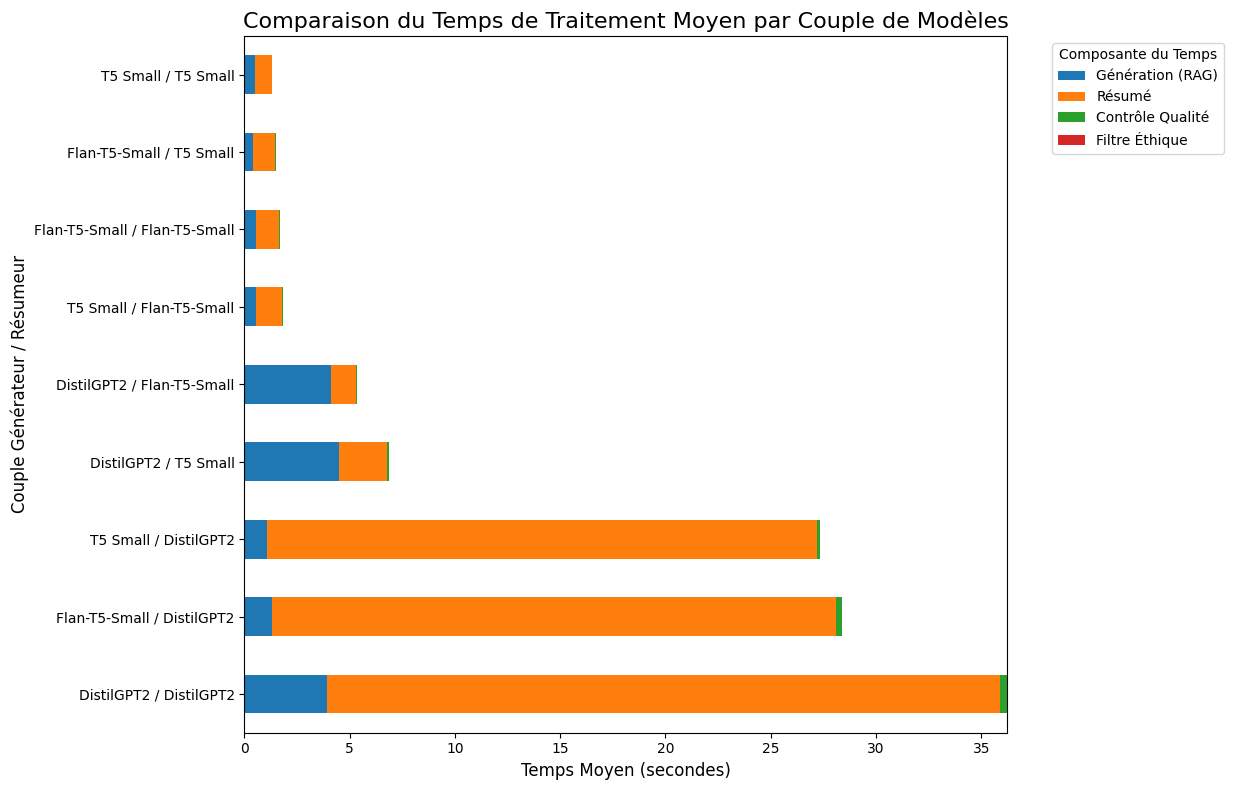

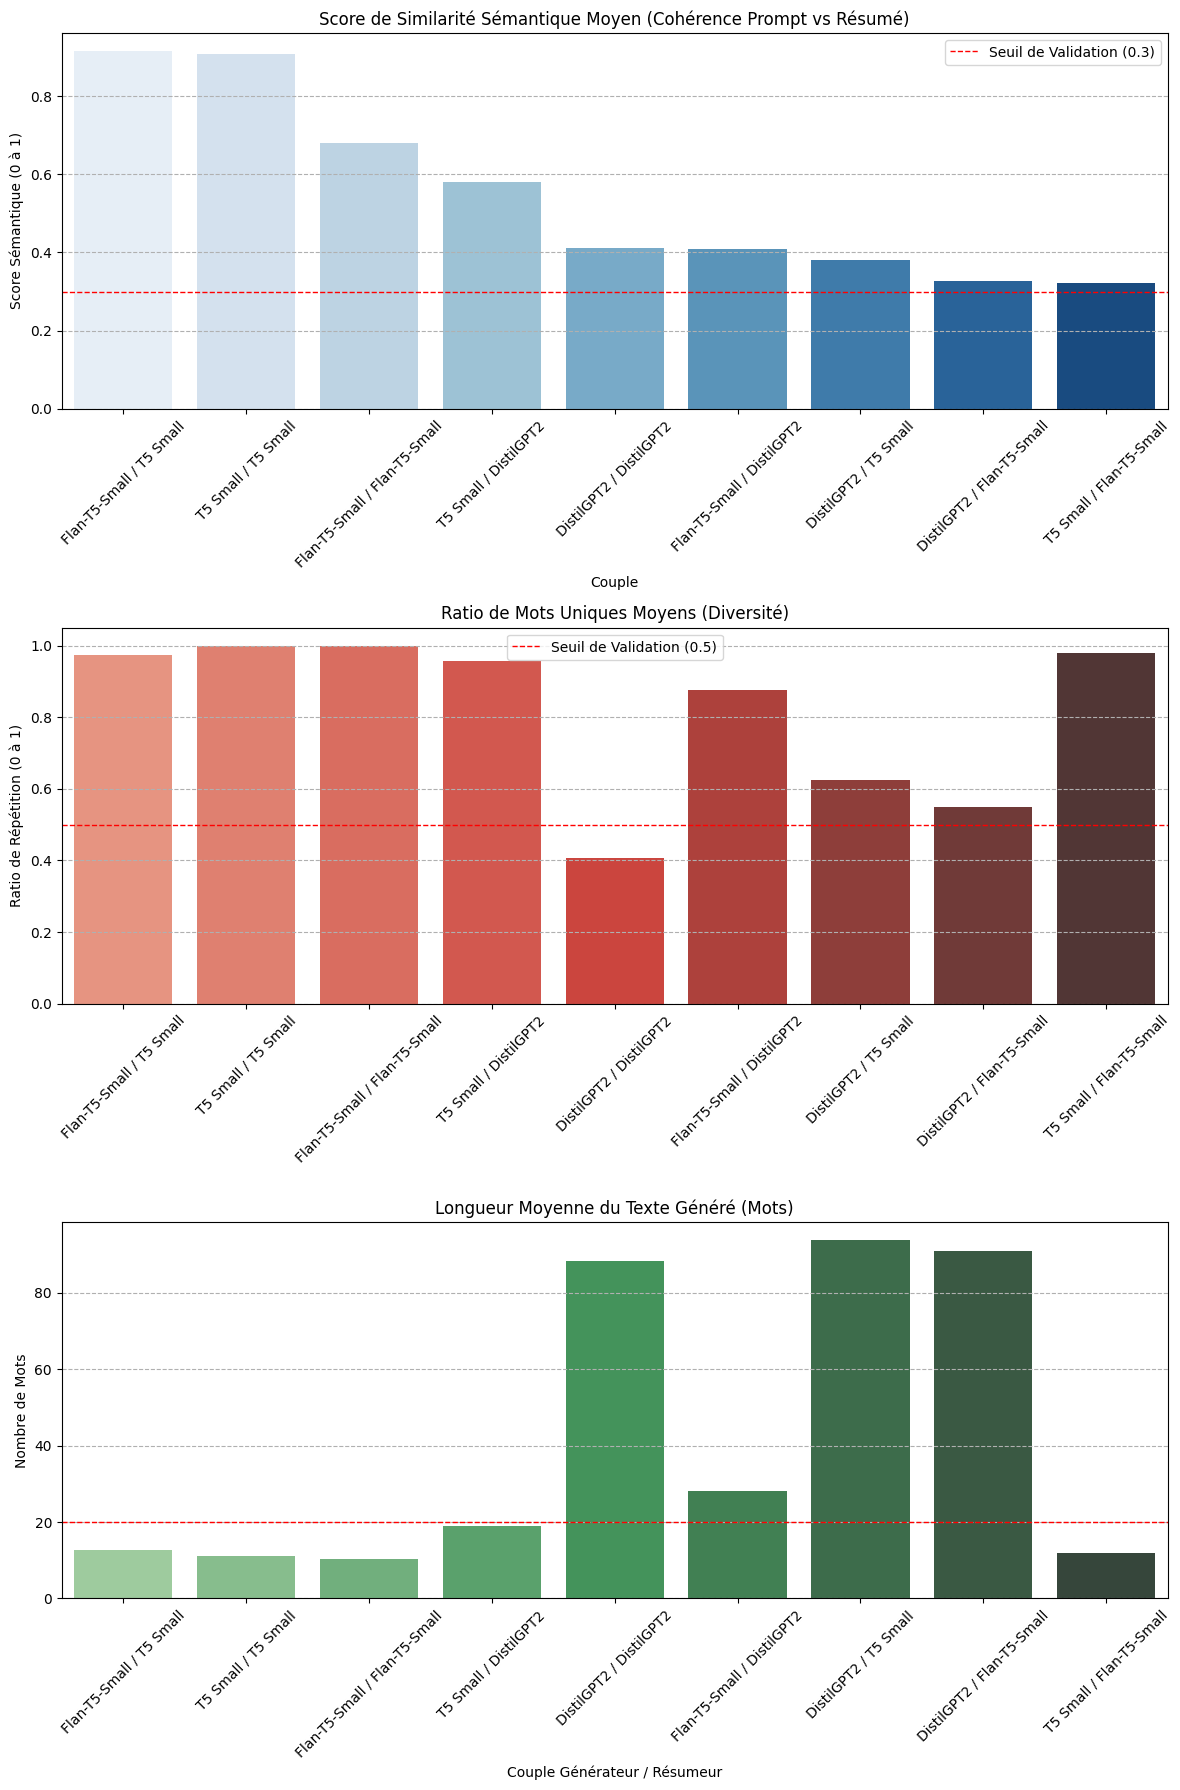

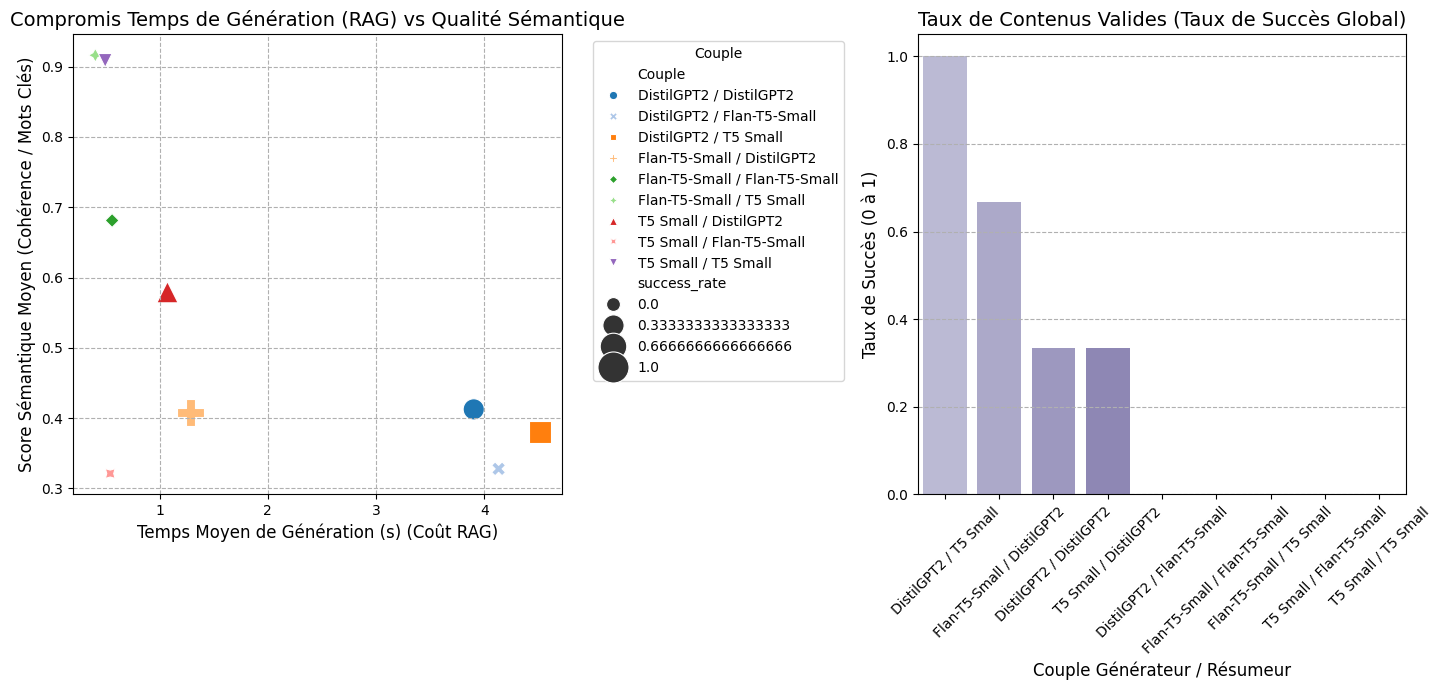

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURATION ---
# Nom du fichier CSV généré par le script de test précédent
CSV_FILENAME = "comparaison_modeles.csv"
OUTPUT_DIR = "graphiques_comparatifs"

# Créer le répertoire de sortie si il n'existe pas
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_and_preprocess_data(filename):
    """Charge les données et calcule les moyennes par couple Générateur-Résumeur."""
    try:
        # Charger les données brutes
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Erreur: Le fichier {filename} n'a pas été trouvé. Assurez-vous qu'il a été généré par le script de test.")
        return None, None

    # Créer une colonne combinée pour le couple Modèle
    df['Couple'] = df['gen_model'] + ' / ' + df['sum_model']

    # Remplacer les NaN (qui peuvent apparaître dans les colonnes métriques pour les REJET_ETHIQUE) par 0
    df = df.fillna(0)

    # Calculer les moyennes par couple pour les temps et les métriques
    mean_df = df.groupby('Couple').agg(
        # Temps de traitement
        mean_total_time=('total_time', 'mean'),
        mean_time_gen=('time_rag_gen', 'mean'),
        mean_time_sum=('time_summary', 'mean'),
        mean_time_qc=('time_qc', 'mean'),
        mean_time_ethic=('time_ethic', 'mean'),

        # Métriques de Qualité
        mean_sem_score=('metric_semantic_score', 'mean'),
        mean_div_ratio=('metric_repetition_ratio', 'mean'),
        mean_length=('metric_length_words', 'mean'),

        # Efficacité (Taux de Succès)
        mean_efficiency=('metric_rag_vs_pipeline', 'mean'),

        # Compter le nombre d'essais par couple pour la vérification
        n_tests=('status', 'count')
    ).reset_index()

    # Calculer le taux de succès (proportion de SUCCES)
    success_rate = df[df['status'] == 'SUCCES'].groupby('Couple')['status'].count() / df.groupby('Couple')['status'].count()
    mean_df['success_rate'] = mean_df['Couple'].map(success_rate).fillna(0)


    print(f"Données chargées et moyennes calculées pour {len(mean_df)} couples.")
    return df, mean_df


# --- 2. FONCTIONS DE VISUALISATION (Changement: on garde les figures ouvertes pour plt.show) ---

def plot_timing_comparison(mean_df):
    """Génère le graphique comparatif des temps de traitement."""

    # Créer un DataFrame pour le graphique en barres empilées
    time_data = mean_df[['Couple', 'mean_time_gen', 'mean_time_sum', 'mean_time_qc', 'mean_time_ethic']]
    time_data = time_data.set_index('Couple')
    time_data.columns = ['Génération (RAG)', 'Résumé', 'Contrôle Qualité', 'Filtre Éthique']

    # Tri par temps total moyen pour une meilleure lisibilité
    time_data = time_data.reindex(mean_df.sort_values(by='mean_total_time', ascending=False)['Couple'])

    plt.figure(figsize=(14, 8))
    # Création du graphique en barres empilées
    time_data.plot(kind='barh', stacked=True, ax=plt.gca())

    plt.title("Comparaison du Temps de Traitement Moyen par Couple de Modèles", fontsize=16)
    plt.xlabel("Temps Moyen (secondes)", fontsize=12)
    plt.ylabel("Couple Générateur / Résumeur", fontsize=12)
    plt.legend(title="Composante du Temps", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(OUTPUT_DIR, "1_Temps_Traitement_Empile.png"))
    # Pas de plt.close() ici pour permettre l'affichage final
    print("Graphique 1 (Temps de Traitement) généré.")

def plot_quality_metrics(mean_df):
    """Génère les graphiques pour les métriques de qualité (Sem-Score, Div, Longueur)."""

    plt.figure(figsize=(12, 18)) # Nouvelle figure pour ce groupe de subplots

    # Tri par score sémantique pour une cohérence visuelle
    sorted_df = mean_df.sort_values(by='mean_sem_score', ascending=False)

    # Utilisation de subplots pour les 3 métriques de qualité

    # 1. Score Sémantique (Mots Clés / Cohérence)
    ax1 = plt.subplot(3, 1, 1)
    sns.barplot(x='Couple', y='mean_sem_score', data=sorted_df, ax=ax1, palette='Blues')
    ax1.axhline(0.3, color='r', linestyle='--', linewidth=1, label="Seuil de Validation (0.3)")
    ax1.set_title('Score de Similarité Sémantique Moyen (Cohérence Prompt vs Résumé)')
    ax1.set_ylabel('Score Sémantique (0 à 1)')
    ax1.legend()

    # 2. Ratio de Répétition (Diversité - Div)
    ax2 = plt.subplot(3, 1, 2, sharex=ax1) # Partage de l'axe X
    sns.barplot(x='Couple', y='mean_div_ratio', data=sorted_df, ax=ax2, palette='Reds_d')
    ax2.axhline(0.5, color='r', linestyle='--', linewidth=1, label="Seuil de Validation (0.5)")
    ax2.set_title('Ratio de Mots Uniques Moyens (Diversité)')
    ax2.set_ylabel('Ratio de Répétition (0 à 1)')
    ax2.legend()
    ax2.set_xlabel('') # Nettoyer l'axe X intermédiaire

    # 3. Longueur Moyenne
    ax3 = plt.subplot(3, 1, 3, sharex=ax1) # Partage de l'axe X
    sns.barplot(x='Couple', y='mean_length', data=sorted_df, ax=ax3, palette='Greens_d')
    ax3.axhline(20, color='r', linestyle='--', linewidth=1, label="Seuil de Validation (20 mots)")
    ax3.set_title('Longueur Moyenne du Texte Généré (Mots)')
    ax3.set_ylabel('Nombre de Mots')

    # Configuration finale
    ax3.set_xlabel('Couple Générateur / Résumeur')
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "2_Metriques_Qualite.png"))
    # Pas de plt.close() ici pour permettre l'affichage final
    print("Graphique 2 (Métriques de Qualité) généré.")

def plot_rag_efficiency(mean_df):
    """Génère le graphique de compromis Temps-Qualité et le taux de succès global."""

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # --- Graphique 3A: Compromis Temps vs Qualité (Efficacité RAG vs Pipeline) ---
    sns.scatterplot(
        x='mean_time_gen',
        y='mean_sem_score',
        hue='Couple',
        size='success_rate',
        sizes=(100, 500),
        data=mean_df,
        ax=axes[0],
        style='Couple',
        palette='tab20'
    )

    axes[0].set_title("Compromis Temps de Génération (RAG) vs Qualité Sémantique", fontsize=14)
    axes[0].set_xlabel("Temps Moyen de Génération (s) (Coût RAG)", fontsize=12)
    axes[0].set_ylabel("Score Sémantique Moyen (Cohérence / Mots Clés)", fontsize=12)
    axes[0].legend(title="Couple", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, linestyle='--')

    # --- Graphique 3B: Taux de Succès Global ---
    sorted_df = mean_df.sort_values(by='success_rate', ascending=False)
    sns.barplot(x='Couple', y='success_rate', data=sorted_df, ax=axes[1], palette='Purples_d')

    axes[1].set_title("Taux de Contenus Valides (Taux de Succès Global)", fontsize=14)
    axes[1].set_ylabel("Taux de Succès (0 à 1)", fontsize=12)
    axes[1].set_xlabel("Couple Générateur / Résumeur", fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', linestyle='--')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(OUTPUT_DIR, "3_Efficacite_RAG_Pipeline.png"))
    # Pas de plt.close() ici pour permettre l'affichage final
    print("Graphique 3 (Efficacité RAG/Pipeline) généré.")

# --- 3. EXÉCUTION PRINCIPALE ---

def main():
    df_raw, df_mean = load_and_preprocess_data(CSV_FILENAME)

    if df_mean is not None:
        print("\nGénération des graphiques...")

        # 1. Temps de traitement
        plot_timing_comparison(df_mean)

        # 2. Qualité des métriques
        plot_quality_metrics(df_mean)

        # 3. Efficacité RAG vs Pipeline
        plot_rag_efficiency(df_mean)

        print(f"\n✅ Tous les graphiques ont été sauvegardés dans le dossier **{OUTPUT_DIR}**.")

        # --- LIGNE CLÉ AJOUTÉE : Affichage de toutes les figures ---
        print("\nAffichage de tous les graphiques générés...")
        plt.show()

if __name__ == "__main__":
    main()